# Overcoming Gibb's: Subtraction methods

This notebook implements two subtraction methods: 
Subtraction of polynomials and trigonometric functions to achieve accurate Fourier transforms of smooth, non-periodic data on a uniform grid.

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
<head>
<title>JabRef References output</title>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<style type="text/css">
body { font-size: 12px; font-family: Arial, sans-serif; }
dt { margin-top: 1em; font-weight: bold; }
@media print {
	dt { page-break-after: avoid; }
	dd { page-break-before: avoid; }
}
</style>
</head>
<body>
<dl>
<dd>Green, M.</dd>
<dd><i>Spectral Solution with a Subtraction Method to Improve Accuracy</i></dd>
<dd><b>2011</b></dd>

</dl>
</body>
</html>

My experience with subtraction methods is positive. They can yield high accuracy for periodic extensions, but not machine precision.
However, for my intended area of application: building a parallelised PDE solver for wave equations with high accuracy, I faced many stability issues. 
For an introduction, I recommend the seminal paper
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
<head>
<title>JabRef References output</title>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<style type="text/css">
body { font-size: 12px; font-family: Arial, sans-serif; }
dt { margin-top: 1em; font-weight: bold; }
@media print {
	dt { page-break-after: avoid; }
	dd { page-break-before: avoid; }
}
</style>
</head>
<body>
<dl>
<dd>Sk&ouml;llermo, G.</dd>
<dd><i>A Fourier method for the numerical solution of Poisson’s equation</i></dd>
<dd>Mathematics of Computation, <b>1975</b>, Vol. 29(131), pp. 697-711</dd>

</dl>
</body>
</html>

The literature suggests different function families as subtraction functions. 

## Trigonometric subtraction

The basic idea of all subtraction methods is similar. 
The version implemented below proceeds as follows: 
- Given a grid: $0, \Delta x, ..., L - \Delta x, L$
- Estimate even derivatives $f^{(0)}(x_0), f^{(0)}(x_1), f^{(2)}(x_0), f^{(2)}(x_1), $... of $f(x)$ at $x_0=0$ and $x_1 = L$ 
- Set them to $0$ by subtracting suitable linear combinations of cosine functions evaluated on the discrete grid
- Define antisymmetric extension as {$f(x_0), ..., f(x_1), -f(x_1 - \Delta x), ..., -f(x_0 + \Delta x)$}
- Accurate Fourier transform of antisymmetric extension


In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def forward_difference_matrix(order, dx):
    """
    Create a forward difference matrix of a given order and spacing.

    Args:
        order (int): The order of the matrix.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The forward difference matrix.
    """
    size = order
    mat = np.zeros((size, size))
    for k in range(1, size + 1):
        for j in range(1, size + 1):
            mat[j - 1, k - 1] = (j * dx) ** k / np.math.factorial(k)

    return mat

def backward_difference_matrix(order, dx):
    """
    Create a backward difference matrix of a given order and spacing.

    Args:
        order (int): The order of the matrix.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The backward difference matrix.
    """
    size = order
    mat = np.zeros((size, size))
    for k in range(1, size + 1):
        for j in range(1, size + 1):
            mat[j - 1, k - 1] = (-j * dx) ** k / np.math.factorial(k)

    return mat

def forward_difference_vector(order, f):
    """
    Create a forward difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The forward difference vector.
    """
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j - 1] = f[j] - f[0]
    return diff

def backward_difference_vector(order, f):
    """
    Create a backward difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The backward difference vector.
    """
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j - 1] = f[-1 - j] - f[-1]
    return diff

def iterative_refinement(A, b, tolerance=1e-9):
    """
    Solve a system of linear equations Ax = b using iterative refinement.

    Args:
        A (numpy.ndarray): The matrix A.
        b (numpy.ndarray): The vector b.
        tolerance (float): The tolerance for the residual error.

    Returns:
        numpy.ndarray: The solution vector x.
    """
    x = np.linalg.solve(A, b)
    residual = b - A @ x
    residual_error = np.sum(np.abs(residual))

    iteration = 0
    while residual_error > tolerance:
        correction = np.linalg.solve(A, residual)
        x += correction
        residual = b - A @ x
        residual_error = np.sum(np.abs(residual))
        iteration += 1
        if iteration > 100:
            break

    return x

def shift_x(x):
    """
    Normalize the x values to a range of [0, 1].

    Args:
        x (numpy.ndarray): The input x values.

    Returns:
        numpy.ndarray: The normalized x values.
    """
    return (x - x[0]) / (x[-1] - x[0])

def cosine_difference_vector(order, f, Dl, Dr):
    """
    Create a cosine difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.
        Dl (numpy.ndarray): The left difference values.
        Dr (numpy.ndarray): The right difference values.

    Returns:
        numpy.ndarray: The cosine difference vector.
    """
    b = np.zeros(2 * order)
    b[0] = f[0]
    b[1] = f[-1]
    for i in range(1, order):
        b[i * 2] = Dl[i] / (np.pi) ** (2 * i)

    for i in range(1, order):
        b[i * 2 + 1] = Dr[i] / (np.pi) ** (2 * i)

    return b

def cosine_difference_matrix(order):
    """
    Create a cosine difference matrix of a given order.

    Args:
        order (int): The order of the matrix.

    Returns:
        numpy.ndarray: The cosine difference matrix.
    """
    A = np.zeros((order * 2, order * 2))
    for i in range(order):
        derivative = 2 * i
        for j in range(1, 2 * order + 1):
            A[2 * i, j - 1] = j ** derivative * (-1) ** i
            A[2 * i + 1, j - 1] = j ** derivative * (-1) ** i * (-1) ** j

    return A

def reconstruct(C, x, derivative_order=0):
    """
    Reconstruct a function from its cosine series coefficients.

    Args:
        C (numpy.ndarray): The cosine series coefficients.
        x (numpy.ndarray): The x values.
        derivative_order (int): The order of the derivative to reconstruct.

    Returns:
        numpy.ndarray: The reconstructed function values.
    """
    f = np.zeros(x.shape)
    L = x[-1] - x[0]
    x_eval = shift_x(x)
    for k in range(1, len(C) + 1):
        f += C[k - 1] * np.real((1j * k * np.pi / L) ** derivative_order * np.exp(1j * k * np.pi * x_eval))

    return f

def get_shift_function(f, order, x):
    """
    Calculate the shift function for a given function, order, and x values.

    Args:
        f (numpy.ndarray): The function values.
        order (int): The order of the shift function.
        x (numpy.ndarray): The x values.

    Returns:
        tuple: The shift function values and the coefficients.
    """
    x_eval = shift_x(x)
    dx = x_eval[1] - x_eval[0]
    A = forward_difference_matrix(order, dx)
    b = forward_difference_vector(order, f)
    Dl = iterative_refinement(A, b)

    A = backward_difference_matrix(order, dx)
    b = backward_difference_vector(order, f)

    Dr = iterative_refinement(A, b)

    A = cosine_difference_matrix(int(order / 2) + 1)
    b = cosine_difference_vector(int(order / 2) + 1, f, Dl, Dr)
    C = iterative_refinement(A, b)

    shift = reconstruct(C, x_eval)
    return shift, C

def antisymmetric_extension(f):
    """
    Extend a function with its antisymmetric part.

    Args:
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The extended function values.
    """
    f_ext = np.concatenate([f, -np.flip(f)[1:-1]])
    return f_ext

def get_k(p, dx):
    """
    Calculate the k values for a given array and spacing.

    Args:
        p (numpy.ndarray): The input array.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The k values.
    """
    N = len(p)
    L = N * dx
    k = 2 * np.pi / L * np.arange(-N / 2, N / 2)
    return np.fft.ifftshift(k)


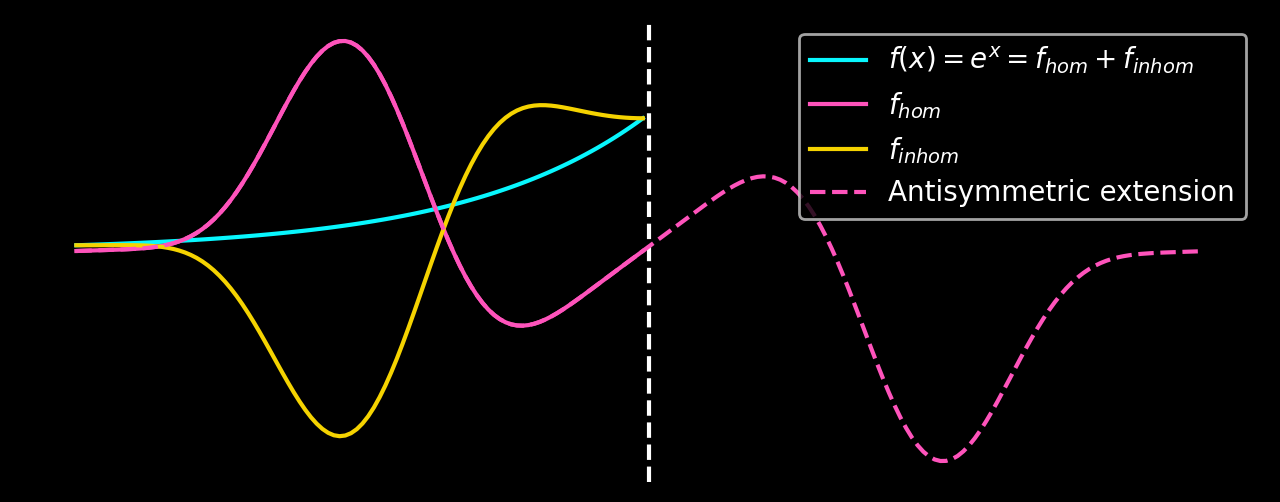

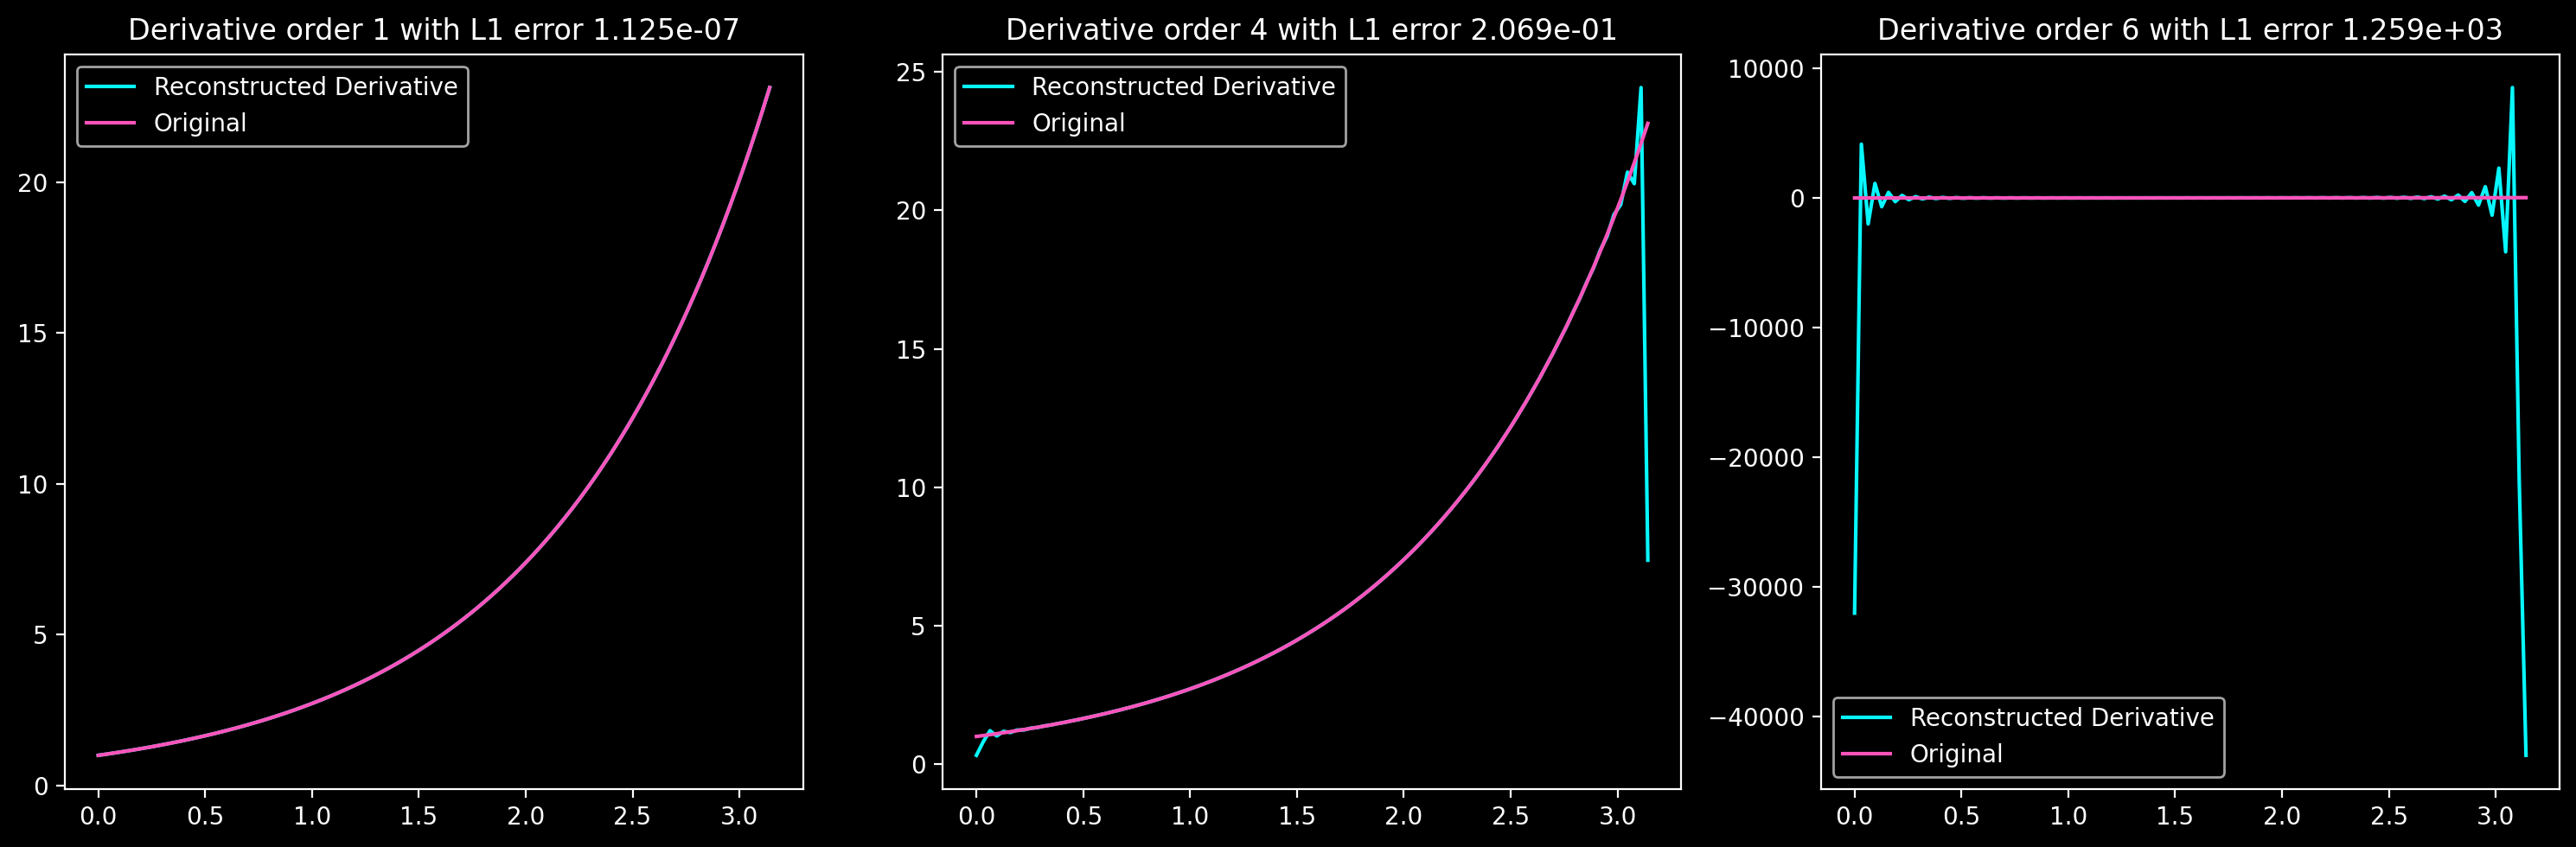

In [48]:


# Configurable parameters
N     = 100  # Size of input domain
order = 5  # Order of the subtraction variables, translates into a sum of 6 cosine functions

# Define the domain and the function
L = np.pi
x = np.linspace(0, L, N)
def func(x):
    return np.exp(x)
f = func(x)
dx = x[1] - x[0]

# Get the shift function and coefficients
shift, C = get_shift_function(f, order, x)
hom      = f - shift
f_ext    = antisymmetric_extension(hom)
f_hat    = scipy.fft.fft(f_ext)

# Get the k values
k = get_k(f_hat, dx)


colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]

plt.style.use('dark_background')
plt.figure(figsize=(8, 3), dpi=200)
plt.axis("off")
plt.plot(f, c = colors[0], label=r"$f(x) = e^x = f_{hom} + f_{inhom}$")
plt.plot(hom, c = colors[1], label=r"$f_{hom}$")
plt.plot(shift, c = colors[2], label=r"$f_{inhom}$")
plt.axvline(len(x), ls="dashed", c="w")
plt.plot(f_ext, c = colors[1], ls="dashed", label="Antisymmetric extension")
plt.legend()
plt.savefig("figures/subtraction_1.png")
plt.show()

# Number of subplots
num_subplots = 3

# Create subplots
fig, axs = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5), dpi=200)

# Loop through different subtraction orders
for i, o in enumerate([1, 4, 6]):
    forg = func(x)
    frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real[:N]  # Use only the first N elements (the original domain)
    reco = reconstruct(C, x, derivative_order = o)
    sumo = frec + reco


    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(sumo - forg)):3.3e}")
    axs[i].plot(x, sumo, label="Reconstructed Derivative", c = colors[0])
    axs[i].plot(x, forg, label="Original", c = colors[1])
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.savefig("figures/subtraction_2.png")
plt.show()


## Polynomial subtraction

For the polynomial subtraction, we demonstrate a slightly different approach. 
- Given a grid: $0, \Delta x, ..., L - \Delta x, L$
- Estimate derivatives $f^{(0)}(x_0), f^{(0)}(x_1), f^{(1)}(x_0), f^{(1)}(x_1), $... of $f(x)$ at $x_0=0$ and $x_1 = L$ 
- Set them to $0$ by subtracting suitable linear combinations of polynomials evaluated on the discrete grid
- Accurate Fourier transform of periodic function

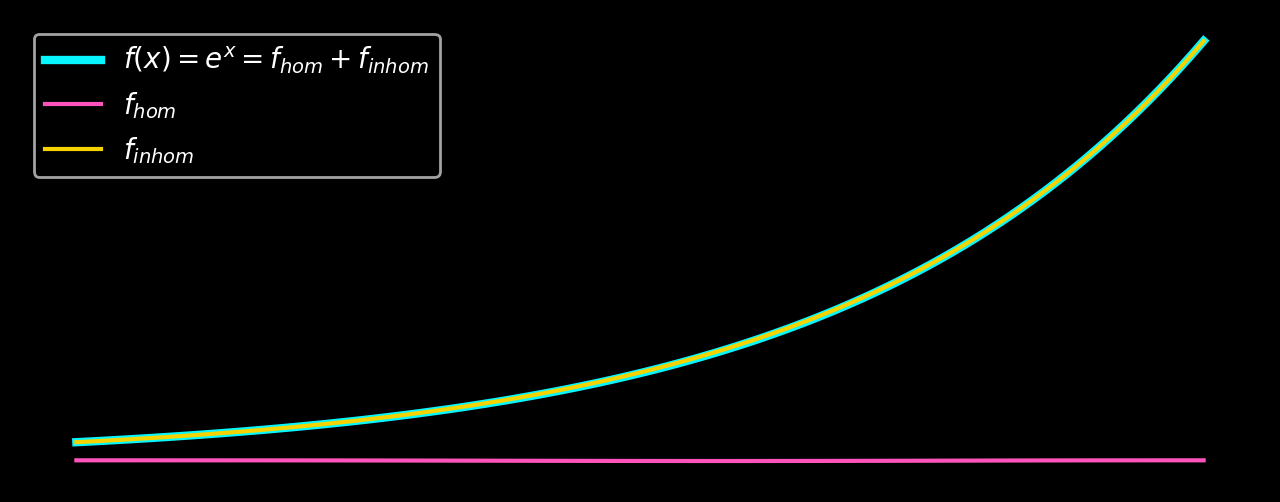

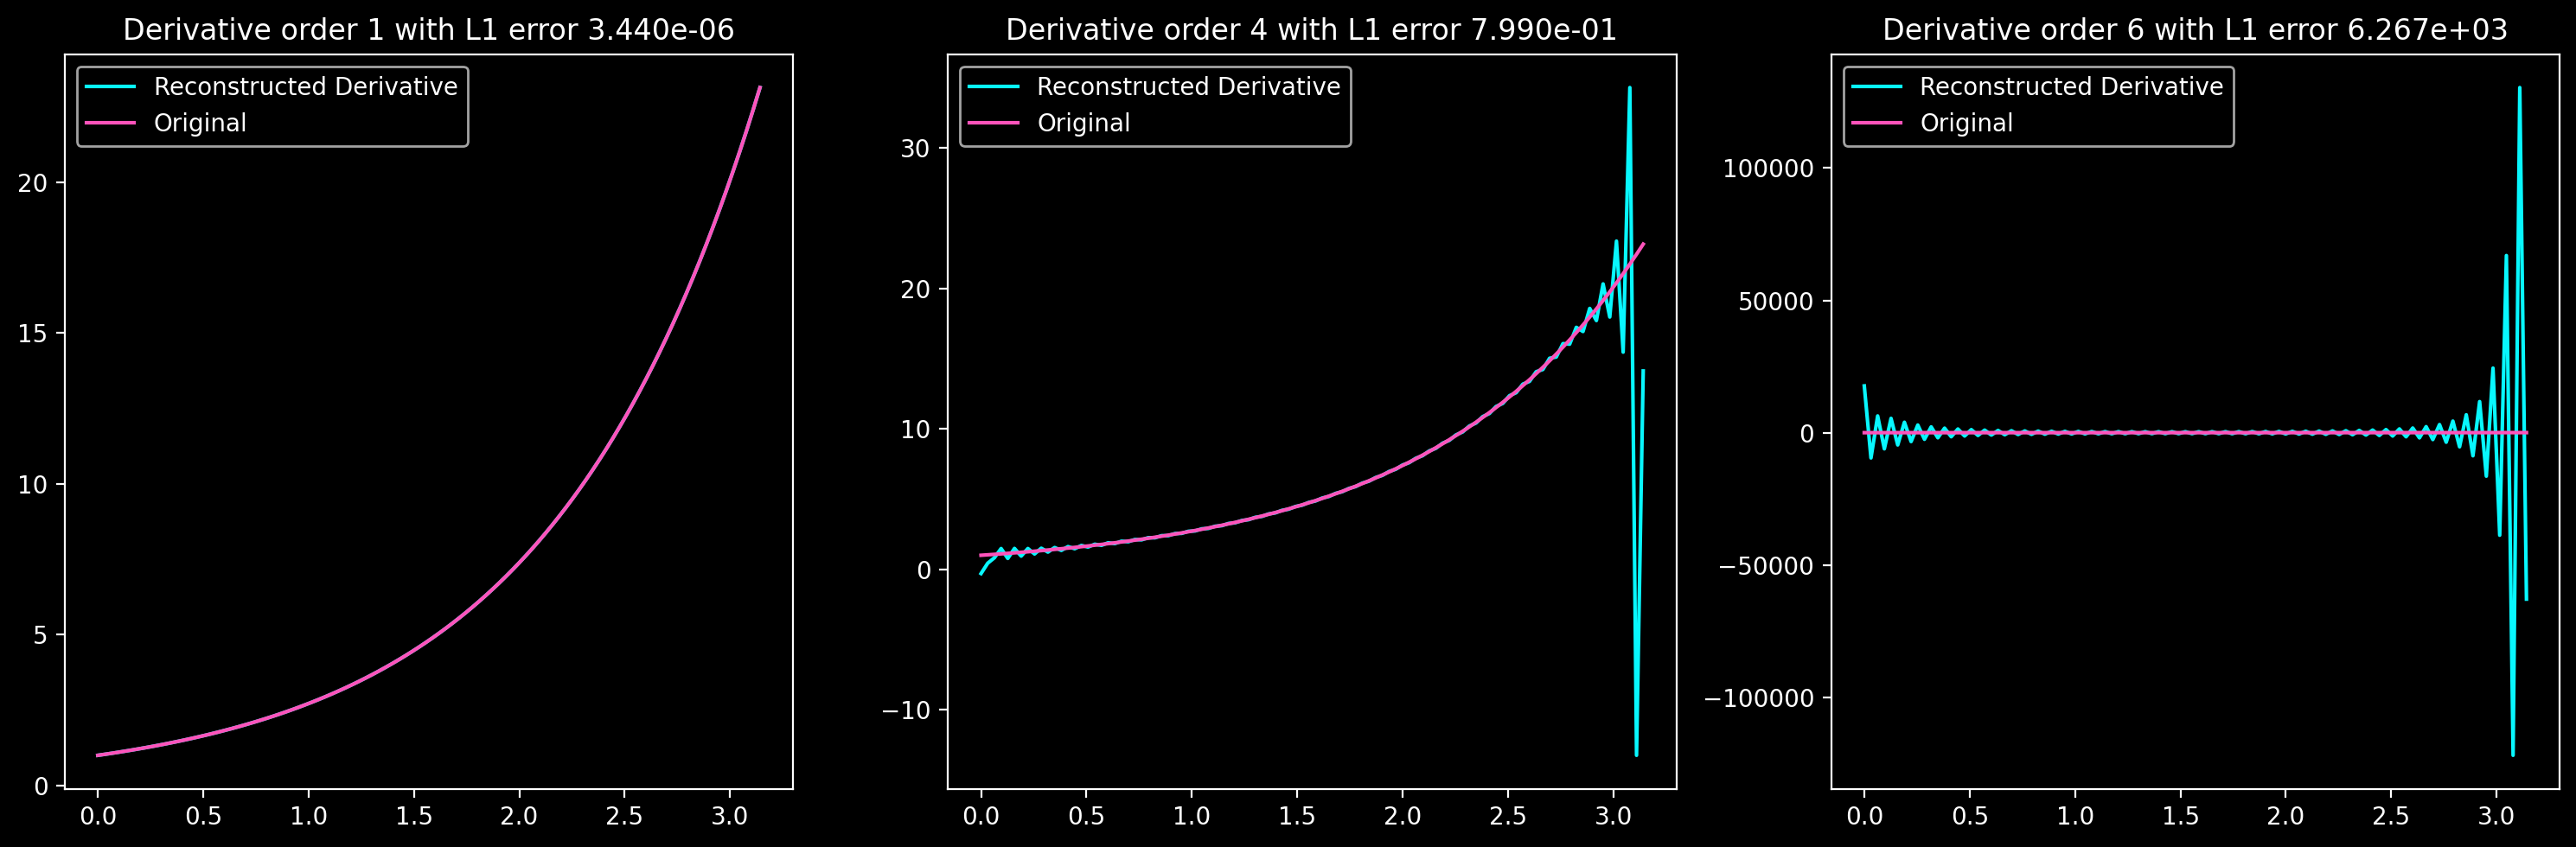

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import scipy.interpolate

# Constants for finite difference modes
MODE_FORWARD = 0
MODE_CENTERED = 1
MODE_BACKWARD = 2
MODE_CUSTOM = 3

# Max derivative order allowed
MAX_DERIVATIVE_ORDER = 30

# Finite difference stencils for forward, backward, and centered modes
fstencils = []
bstencils = []
cstencils = []


def compute_fd_coefficients(derivative_order, accuracy, mode, stencil=None):
    """
    Compute finite difference coefficients for given derivative order and accuracy.

    Args:
        derivative_order (int): The order of the derivative.
        accuracy (int): The accuracy of the approximation.
        mode (int): The mode of finite difference (forward, backward, centered, custom).
        stencil (np.array): The points used for the finite difference.

    Returns:
        tuple: A tuple containing the stencil and the coefficients.
    """
    stencil_length = derivative_order + accuracy

    if mode == MODE_FORWARD:
        stencil = np.arange(0, stencil_length)
    elif mode == MODE_BACKWARD:
        stencil = np.arange(-stencil_length + 1, 1)
    elif mode == MODE_CENTERED:
        if accuracy % 2 != 0:
            raise ValueError("Centered stencils available only with even accuracy orders")
        if (stencil_length % 2 == 0) and stencil_length >= 4:
            stencil_length -= 1
        half_stencil_length = int((stencil_length - 1) / 2)
        stencil = np.arange(-half_stencil_length, half_stencil_length + 1)
    elif mode == MODE_CUSTOM:
        if stencil is None:
            raise ValueError("Custom stencil needed in MODE_CUSTOM")
        stencil_length = len(stencil)
        if derivative_order >= stencil_length:
            raise ValueError("Derivative order must be smaller than stencil length")

    A = np.zeros((stencil_length, stencil_length))
    b = np.zeros(stencil_length)

    for i in range(stencil_length):
        A[i, :] = stencil ** i
    b[derivative_order] = np.math.factorial(derivative_order)

    coefficients = np.linalg.solve(A, b)
    return stencil, coefficients


# Populate the finite difference stencils for forward, backward, and centered modes
for i in range(MAX_DERIVATIVE_ORDER):
    N_MAX = i + 2
    fstencils_at_order_i = []
    bstencils_at_order_i = []
    cstencils_at_order_i = []
    for order in range(1, N_MAX):
        c = compute_fd_coefficients(order, N_MAX - order + ((N_MAX - order) % 2 != 0), MODE_CENTERED)
        f = compute_fd_coefficients(order, N_MAX - order, MODE_FORWARD)
        b = compute_fd_coefficients(order, N_MAX - order, MODE_BACKWARD)
        fstencils_at_order_i.append(f)
        bstencils_at_order_i.append(b)
        cstencils_at_order_i.append(c)
    fstencils.append(fstencils_at_order_i)
    bstencils.append(bstencils_at_order_i)
    cstencils.append(cstencils_at_order_i)


def compute_derivative(f, j, dx, stencil, derivative_order=1):
    """
    Compute the derivative of a function at a point.

    Args:
        f (np.array): The function values.
        j (int): The index of the point.
        dx (float): The spacing between points.
        stencil (tuple): The stencil and coefficients for finite differences.
        derivative_order (int): The order of the derivative.

    Returns:
        float: The derivative of the function at point j.
    """
    shifts, coeff = stencil
    f_dx = sum(f[j + shift] * coeff[i] for i, shift in enumerate(shifts))
    return f_dx / dx ** derivative_order


def get_polynomial_shift_function(x, f, N=0):
    """
    Compute the polynomial shift function to fulfill Dirichlet boundary conditions.

    Args:
        x (np.array): The domain of the function.
        f (np.array): The function values.
        N (int): The order of the polynomial.

    Returns:
        tuple: The polynomial shift function and the interpolating polynomial.
    """
    dx = x[1] - x[0]
    x0, x1 = x[0], x[-1]
    f0, f1 = f[0], f[-1]

    N_columns = 1 + N
    fd_f_stencil = fstencils[N - 1]
    fd_b_stencil = bstencils[N - 1]

    B = np.zeros((N_columns, len(f)), f.dtype)

    bc_l = [(i + 1, compute_derivative(f, 0, dx, fd_f_stencil[i], i + 1)) for i in range(N)]
    bc_r = [(i + 1, compute_derivative(f, -1, dx, fd_b_stencil[i], i + 1)) for i in range(N)]

    bc = (bc_l, bc_r)

    poly = scipy.interpolate.make_interp_spline([x0, x1], [f0, f1], k=2 * N + 1, bc_type=bc, axis=0)

    for i in range(N + 1):
        B[i] = poly(x, i * 2)

    return B[:, :len(x)], poly


# Configurable parameters
N     = 100  # Size of input domain
order = 3    # Order of the subtraction variables, this leads to a 2*order + 1-th degree polynomials being subtraction from the original function

# Define the domain and the function
L = np.pi
x = np.linspace(0, L, N)


def func(x):
    """Function to compute e^x."""
    return np.exp(x)


f = func(x)
dx = x[1] - x[0]

# Create shift function such that f - B fulfills Dirichlet boundary conditions
shift, polynomial_func = get_polynomial_shift_function(x, f, N=order)
f_ext = f - shift[0]
f_hat = scipy.fft.fft(f_ext)

# Function to get k values
k = get_k(f_hat, dx)

colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]

plt.style.use('dark_background')
plt.figure(figsize=(8, 3), dpi=200)
plt.axis("off")
plt.plot(f, c=colors[0], lw=3, label=r"$f(x) = e^x = f_{hom} + f_{inhom}$")
plt.plot(f_ext, c=colors[1], label=r"$f_{hom}$")
plt.plot(shift[0], c=colors[2], label=r"$f_{inhom}$")
plt.legend()
plt.savefig("figures/subtraction_3.png")
plt.show()

# Number of subplots
num_subplots = 3

# Create subplots
fig, axs = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5), dpi=200)

# Loop through different subtraction orders
for i, o in enumerate([1, 4, 6]):
    forg = func(x)
    frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real  # Use only the first N elements (the original domain)
    reco = polynomial_func(x, o)
    sumo = frec + reco

    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(sumo - forg)):3.3e}")
    axs[i].plot(x, sumo, label="Reconstructed Derivative", c=colors[0])
    axs[i].plot(x, forg, label="Original", c=colors[1])
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.savefig("figures/subtraction_4.png")
plt.show()


Note that the 6th derivative suffers from order unity errors since we only ensure that the homogeneous function is periodic up to fifth order. For a mathematical analysis, see the Sköllermo paper. 